In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import yaml
from pathlib import Path
import time

from tardigrade_functions import get_bouts, calculate_mean_values, calculate_mode_values

In [3]:
date = time.strftime("%Y%m%d")
home = os.path.expanduser("~")
inpath = os.path.join(home, f'data/tardigrade/out_{date}')
pose_path = os.path.join(home, 'data/tardigrade/poseestimation')

stance_files = {''.join(name.split('_stance.csv')): os.path.join(root, name) for root, dirs, files in os.walk(inpath) for name in files if '_stance.csv' in name}
turns_files = {''.join(name.split('_turns.csv')): os.path.join(root, name) for root, dirs, files in os.walk(inpath) for name in files if '_turns.csv' in name}
stage_files = {''.join(name.split('_stage.csv')): os.path.join(root, name) for root, dirs, files in os.walk(inpath) for name in files if '_stage.csv' in name}
pose_files = {}

fpath = Path(pose_path)
for id in stance_files.keys():
    for fn in list(filter(Path.is_file, fpath.glob(id+'*.csv'))):
        if id in pose_files.keys():
            print(f'Warning {id} already in pose_files')
            break
        pose_files[id] = os.path.join(pose_path, fn)


In [ ]:
config_path = "tardigrade_config.yaml"
config = yaml.safe_load(open(config_path, "r"))

fps = config['video']['fps']
umpxl = eval(config['video']['umpxl'])
length = config['video']['length']
use_matrix = config['analysis']['use_matrix']

param = {'scale':umpxl, 'fps':fps, 'use_matrix':use_matrix,'length':length,}

bodyparts = config['analysis']['bodyparts']
limbs = config['analysis']['limbs']
pairs = config['analysis']['pairs']
bp_pairs = config['analysis']['bp_pairs']

bp_color_dict = config['color']['bp_color']

idx = pd.IndexSlice

In [5]:
snippets = {
    '12MM_30FPS_1':[(0,500), (100,1900), (5000,5900)], 
    '12MM_30FPS_2':[(1000,2000), (2500,3000)], 
    '12MM_30FPS_offFOOD_3':[(500,2500), (6000,9000)],
    '12MM_30FPS_offFOOD_4':[(2000,4000)], 
    '12MM_30FPS_offFOOD_5':[(0,400), (100,1500), (3000,5000)], 
}

In [6]:
all_confident_stance = pd.DataFrame([])
all_confident_stage = pd.DataFrame([])
offset = 0
for i,id in enumerate(pose_files):
    print(id)
    if id not in snippets.keys():
        continue
    stance = pd.read_csv(stance_files[id], index_col=0).reset_index(drop=True)
    stage = pd.read_csv(stage_files[id], index_col=0).reset_index(drop=True)
    stage['id'] = id
    stage['condition'] = 'on food' if not 'offFOOD' in id else 'off food'

    for sn in snippets[id]:
        print(sn)
        confident_stance = stance.iloc[range(sn[0],sn[1])].reset_index(drop=True)
        confident_stage = stage.iloc[range(sn[0],sn[1])].reset_index(drop=True)
        
        confident_stance.index = confident_stance.index + offset
        confident_stage.index = confident_stage.index + offset

        all_confident_stance = pd.concat([all_confident_stance, confident_stance],axis=0)
        all_confident_stage = pd.concat([all_confident_stage, confident_stage],axis=0)
    
        offset = np.max(all_confident_stance.index)+1000
        
all_confident_stance = all_confident_stance.reindex(index=range(0, np.max(all_confident_stance.index))).fillna(0)

12MM_30FPS_1
(0, 500)
(100, 1900)
(5000, 5900)
12MM_30FPS_2
(1000, 2000)
(2500, 3000)
12MM_30FPS_offFOOD_3
(500, 2500)
(6000, 9000)
12MM_30FPS_offFOOD_4
(2000, 4000)
12MM_30FPS_offFOOD_5
(0, 400)
(100, 1500)
(3000, 5000)


(-0.5, 25488.5, 11.5, -0.5)

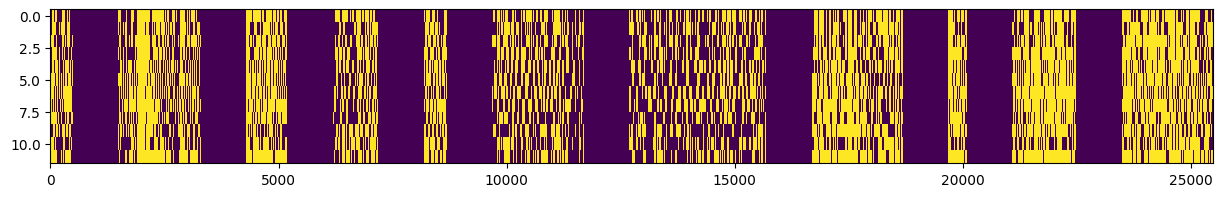

In [7]:
fig = plt.figure( figsize=(15,2))
plt.imshow(all_confident_stance.T.astype(int), interpolation='none')
plt.axis('auto')

In [8]:
bout_stance = get_bouts(all_confident_stance.astype(bool))
bout_swing = get_bouts(~ all_confident_stance.astype(bool))

In [9]:
dur_stance = pd.DataFrame(dict([ (k,pd.Series(np.array(v)[:,1])) for k,v in bout_stance.items() ]))
on_stance = pd.DataFrame(dict([ (k,pd.Series(np.array(v)[:,0])) for k,v in bout_stance.items() ]))
dur_swing = pd.DataFrame(dict([ (k,pd.Series(np.array(v)[:,1])) for k,v in bout_swing.items() ]))
on_swing = pd.DataFrame(dict([ (k,pd.Series(np.array(v)[:,0])) for k,v in bout_swing.items() ]))

In [10]:
# Calculate mean values
stance_meanvelo = calculate_mean_values(on_stance, dur_stance, all_confident_stage.velocity)
swing_meanvelo = calculate_mean_values(on_swing, dur_swing, all_confident_stage.velocity)

In [11]:
stance_condition = calculate_mode_values(on_stance, dur_stance, all_confident_stage.condition)
swing_condition = calculate_mode_values(on_swing, dur_swing, all_confident_stage.condition)

In [29]:
categories = np.unique(all_confident_stage.condition)
colors = np.linspace(0, 1, len(categories))
colordict = {'off food': '#000000', 'on food': '#31439A'}
stance_color = stance_condition.copy().replace(colordict)
swing_color = swing_condition.copy().replace(colordict)

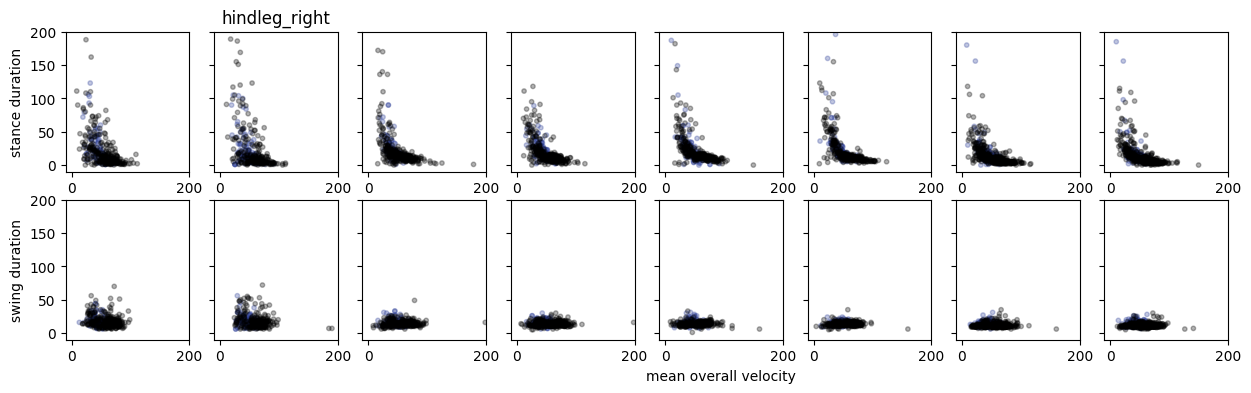

In [30]:
fig, axs = plt.subplots(2, len(limbs), figsize=(15,4), sharey=True)
for i, l in enumerate(limbs):
    stance_idx = stance_color[l].dropna().index
    swing_idx = swing_color[l].dropna().index
    axs[0,i].scatter(stance_meanvelo[l].iloc[stance_idx], dur_stance[l].iloc[stance_idx], s=10, c=stance_color[l].iloc[stance_idx], alpha=.3)
    axs[1,i].scatter(swing_meanvelo[l].iloc[swing_idx],dur_swing[l].iloc[swing_idx], s=10, c=swing_color[l].iloc[swing_idx], alpha=.3)
    axs[0,1].set_title(l)
axs[0,0].set_ylabel('stance duration')
axs[1,0].set_ylabel('swing duration')
axs[1,len(limbs)//2].set_xlabel('mean overall velocity')

for ax in axs.flatten():
    ax.set_ylim(-10,200)  
    ax.set_xlim(-10,200)
plt.savefig(os.path.join(inpath, f'{id}_velocity_bps.pdf'), bbox_inches='tight')
plt.show()

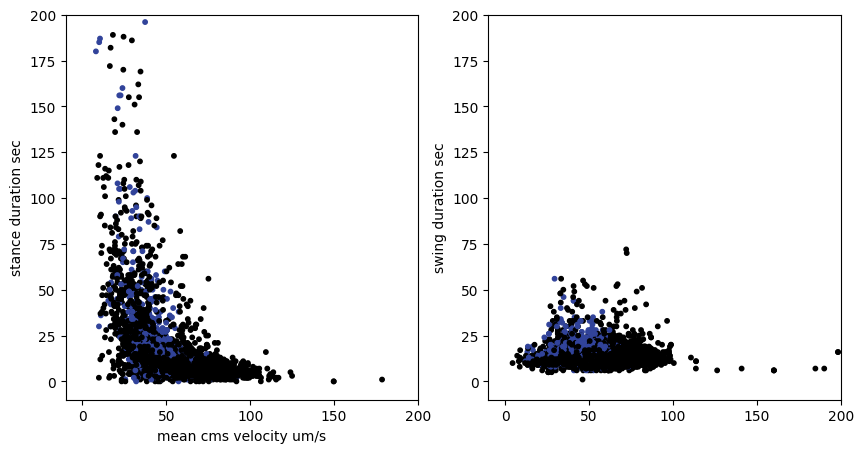

In [33]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
for l in limbs:
    stance_idx = stance_color[l].dropna().index
    swing_idx = swing_color[l].dropna().index
    axs[0].scatter(stance_meanvelo[l].iloc[stance_idx],dur_stance[l].iloc[stance_idx], s=10, c=stance_color[l].iloc[stance_idx])
    axs[1].scatter(swing_meanvelo[l].iloc[swing_idx],dur_swing[l].iloc[swing_idx], s=10, c=swing_color[l].iloc[swing_idx])
    axs[0].set_ylabel('stance duration sec')
    axs[1].set_ylabel('swing duration sec')
axs[0].set_xlabel('mean cms velocity um/s')
for ax in axs.flatten():    
    ax.set_ylim(-10,200)  
    ax.set_xlim(-10,200)
    
plt.savefig(os.path.join(inpath, f'{id}_velocity.pdf'), bbox_inches='tight')

In [26]:
for i, group in all_confident_stage.groupby('condition'):
    print(i, 'mean:', np.round(group['velocity'].mean(),2), 'std:', np.round(group['velocity'].std(),2))

off food mean: 48.06 std: 24.34
on food mean: 40.21 std: 15.07
